In [1]:
import platform
import sys
import datetime
import netCDF4
import numpy as np

if platform.system() == 'Darwin':
    base_FP = '/Users/Google_Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/Volumes/Data'
else:
    base_FP = '/home/Google Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/media/Data'

import hydroAI.TC_like as TCL
import hydroAI.Plot as Plot
import hydroAI.Data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 1. Load resampled data, select time-period, and convert ASCAT SWI to VSM. 

### 1.1. Stduy domain

In [2]:
domain_nc_file = base_FP+'/Lab/2023_DA_TCA/libs/lis_input_noah33.nc'
nc_data = netCDF4.Dataset(domain_nc_file)
domain_lat = np.flipud(nc_data.variables['lat'][:]).data
domain_lon = np.flipud(nc_data.variables['lon'][:]).data
nc_data.close()

### 1.2. Specify the time-period.

In [3]:
start_date = datetime.datetime(2022, 4, 1)
end_date   = datetime.datetime(2022, 4, 30)

# Calculate the day of year values
doy1 = start_date.timetuple().tm_yday
doy2 = end_date.timetuple().tm_yday

In [4]:
nc_file_Porosity = nc_save_dir+'/extracted_nc/PORO_R_Noah_025.nc'
nc_data_PORO   = netCDF4.Dataset(nc_file_Porosity)
Porosity       = nc_data_PORO.variables['Porosity'][:].data

m, n = Porosity.shape; z = doy2-doy1+1

path_list = ['am', 'pm']
RFI_th = 0.9

#combined the am and pm data sets
ASCAT_SM_am_pm = np.zeros((m, n, z*2), dtype='float64')
SMOS_SM_am_pm  = np.zeros((m, n, z*2), dtype='float64')

for path in path_list:
    nc_file_SMOS   = nc_save_dir+'/extracted_nc/SMOS_IC_2022_'+path+'_R_Noah_025.nc'
    nc_file_ASCAT  = nc_save_dir+'/extracted_nc/ASCAT_TUW_2022_'+path+'_R_Noah_025.nc'

    nc_data_SMOS = netCDF4.Dataset(nc_file_SMOS)
    SMOS_SM      = nc_data_SMOS.variables['SMOS_SM'][:].data
    SMOS_RFI     = nc_data_SMOS.variables['SMOS_RFI'][:].data
    SMOS_SM[SMOS_RFI>RFI_th] = np.nan
    sub_SMOS_SM  = SMOS_SM[:,:, doy1:doy2+1]

    nc_data_ASCAT = netCDF4.Dataset(nc_file_ASCAT)
    ASCAT_SWI     = nc_data_ASCAT.variables['ASCAT_SM'][:].data
    sub_ASCAT_SM  = ASCAT_SWI[:,:, doy1-1:doy2]/10000*np.expand_dims(Porosity, axis=2)

    if path == 'am':
        SMOS_SM_am_pm[:, :,  ::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, ::2]  = sub_ASCAT_SM
    else:
        SMOS_SM_am_pm[:, :, 1::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, 1::2] = sub_ASCAT_SM

In [5]:
ma_SMOS_SM_am_pm  = Data.moving_average_3d(SMOS_SM_am_pm, 5)
ma_ASCAT_SM_am_pm = Data.moving_average_3d(ASCAT_SM_am_pm, 5)

# pseudo DA_SM data. Generated from the ASCAT SM data with white noise.
temp_error = np.random.normal(loc=0, scale=0.05, size=(m, n, z*2))
DA_SM      = ASCAT_SM_am_pm + temp_error
ma_DA_SM   = Data.moving_average_3d(DA_SM, 5)

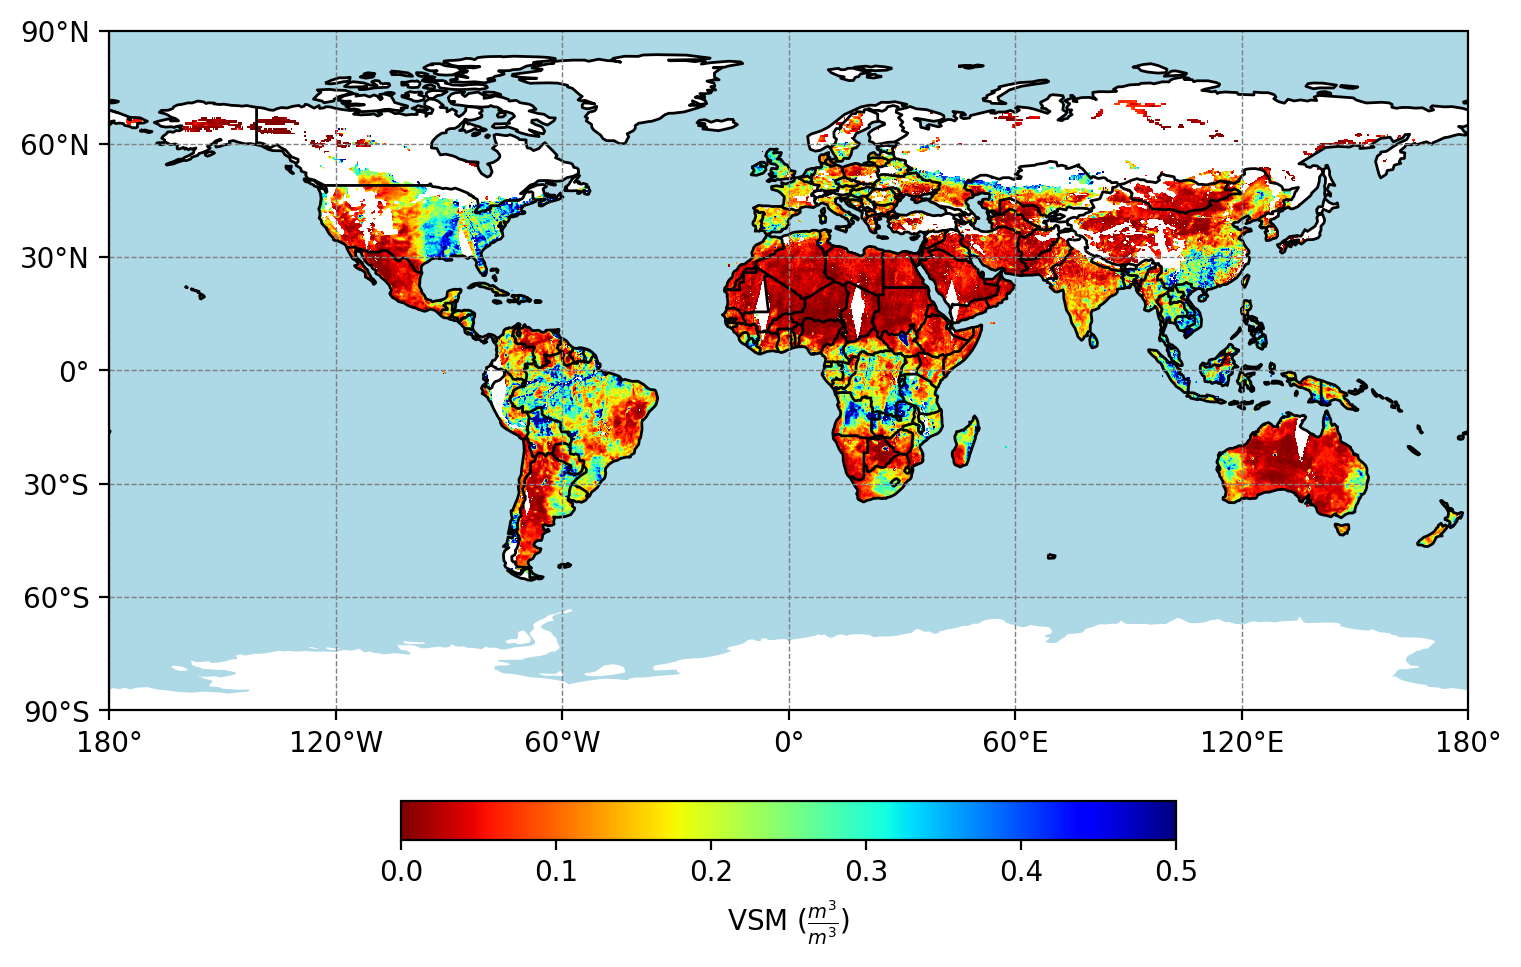

In [12]:
Plot.plot_global_map(domain_lon, domain_lat, ma_SMOS_SM_am_pm[:,:,1], r'VSM ($\frac{m^3}{m^3}$)', 0, 0.5, 'jet_r')

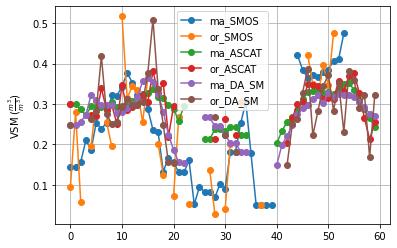

In [6]:
# Check the moving-averaged SM vs originia SM data sets
t1 = np.sum(ma_SMOS_SM_am_pm>0,2)
t2 = np.sum(ma_ASCAT_SM_am_pm>0,2)
row_indices, col_indices = np.where((t1 > 20) & (t2 > 20))
idx = 1305

plt.plot(ma_SMOS_SM_am_pm[row_indices[idx], col_indices[idx],:],'-o', label='ma_SMOS')
plt.plot(SMOS_SM_am_pm[row_indices[idx], col_indices[idx],:], '-o', label='or_SMOS')

plt.plot(ma_ASCAT_SM_am_pm[row_indices[idx], col_indices[idx],:],'-o', label='ma_ASCAT')
plt.plot(ASCAT_SM_am_pm[row_indices[idx], col_indices[idx],:], '-o', label='or_ASCAT')

plt.plot(ma_DA_SM[row_indices[idx], col_indices[idx],:],'-o', label='ma_DA_SM')
plt.plot(DA_SM[row_indices[idx], col_indices[idx],:], '-o', label='or_DA_SM')

plt.legend()
plt.grid()
plt.ylabel(r'VSM ($\frac{m^3}{m^3}$)');

### 1.3 Calcuate the TC numbers

In [7]:
D1 = ma_SMOS_SM_am_pm
D2 = ma_ASCAT_SM_am_pm
D3 = ma_DA_SM
fMSE = TCL.TCA(D1, D2, D3, nod_th=20, corr_th=0.1, REF=None)[4]

### 1.4 Check the results

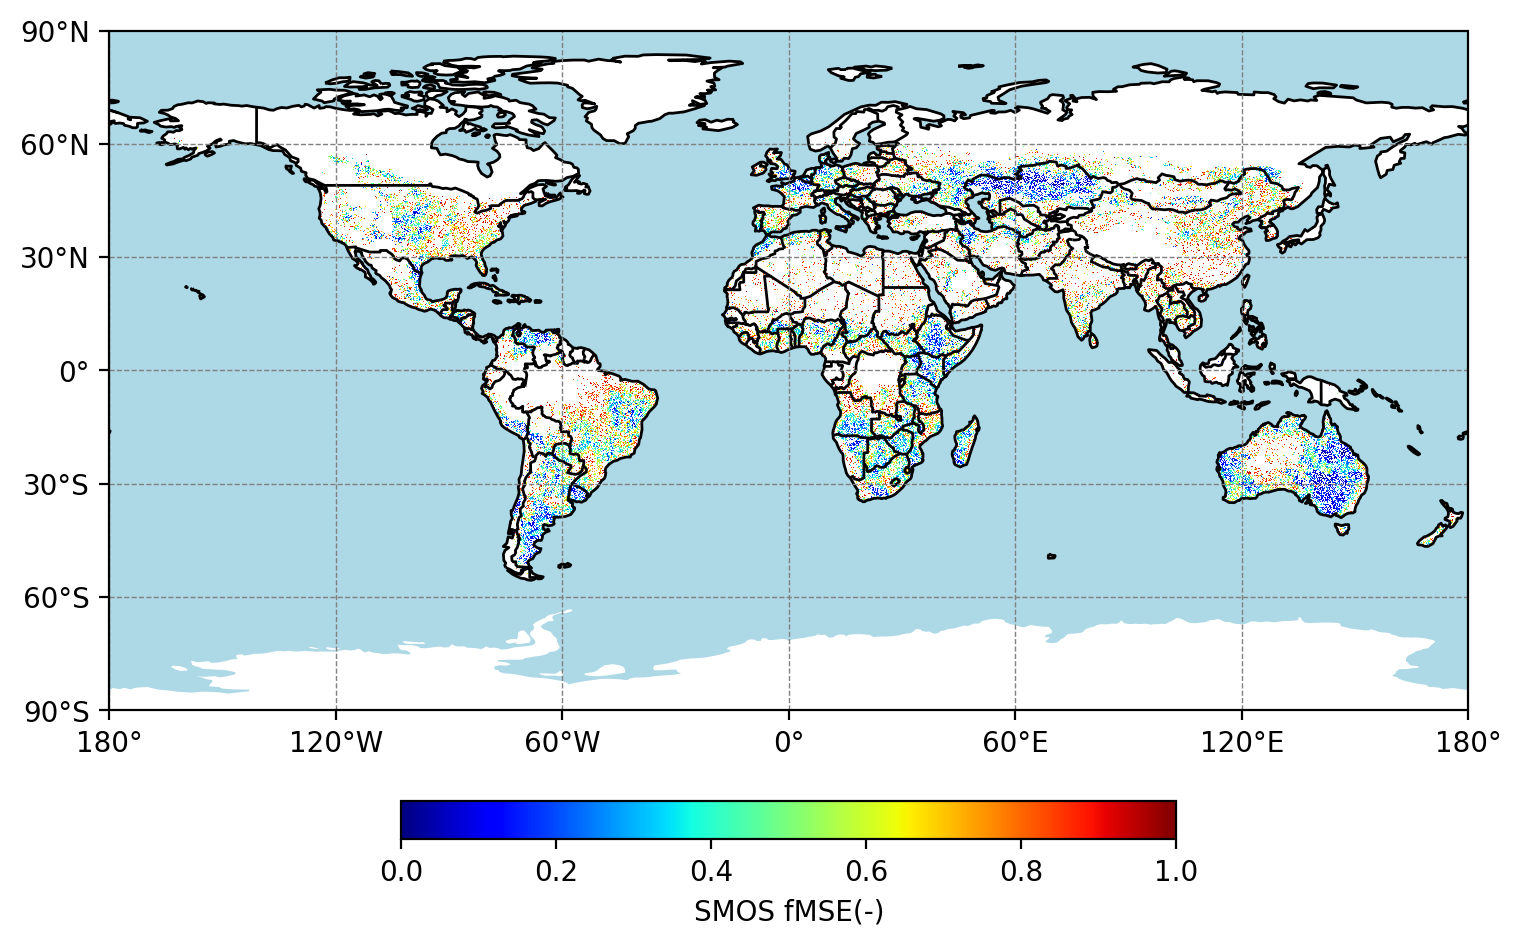

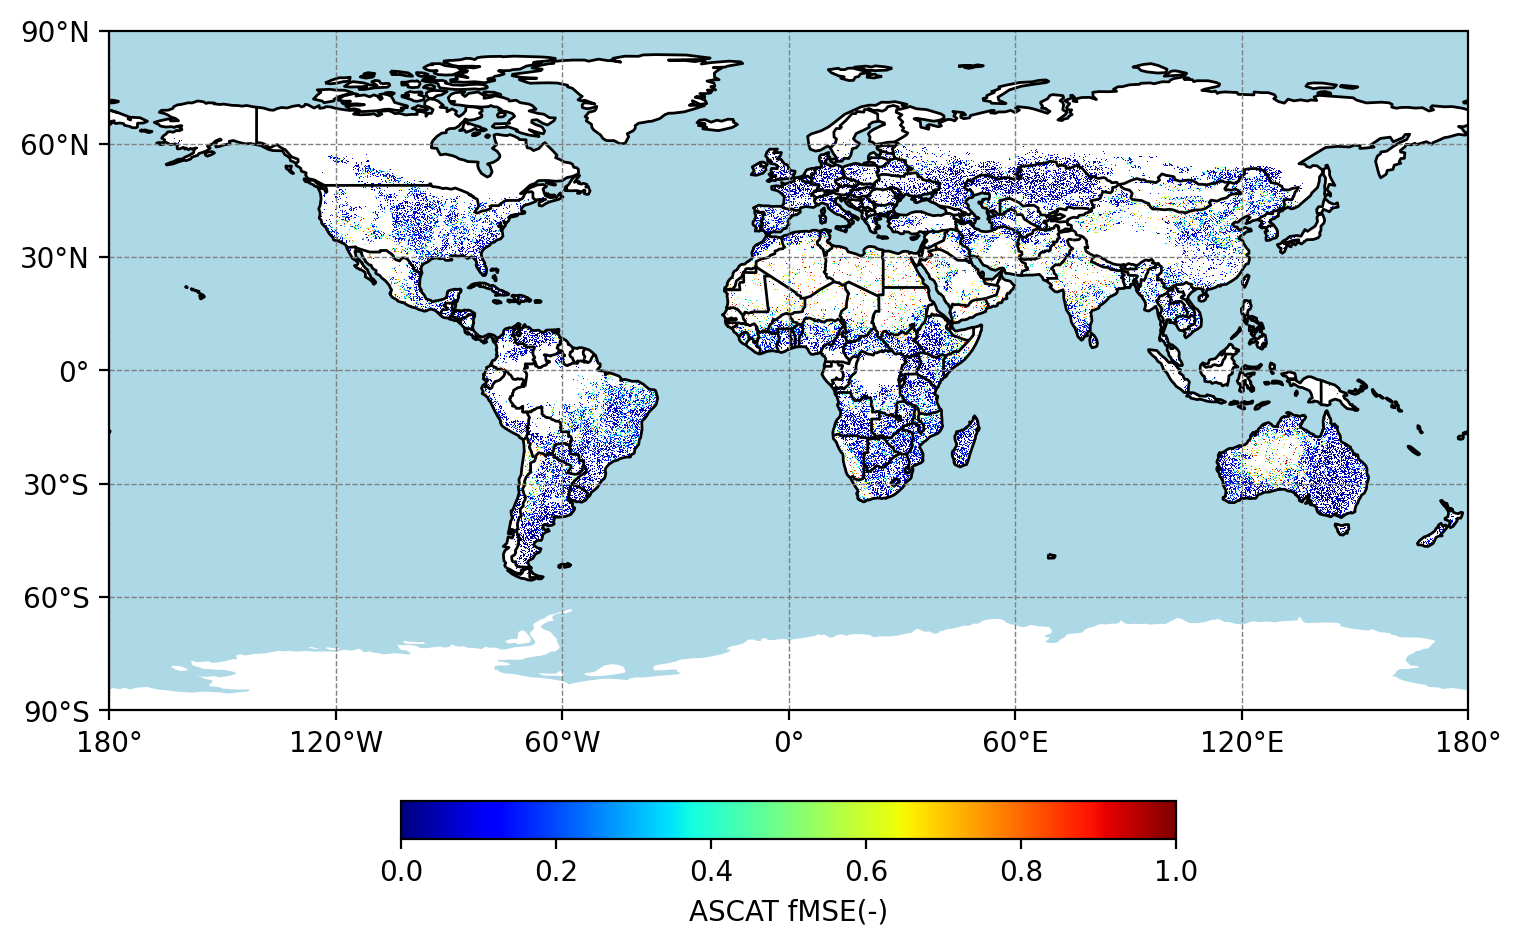

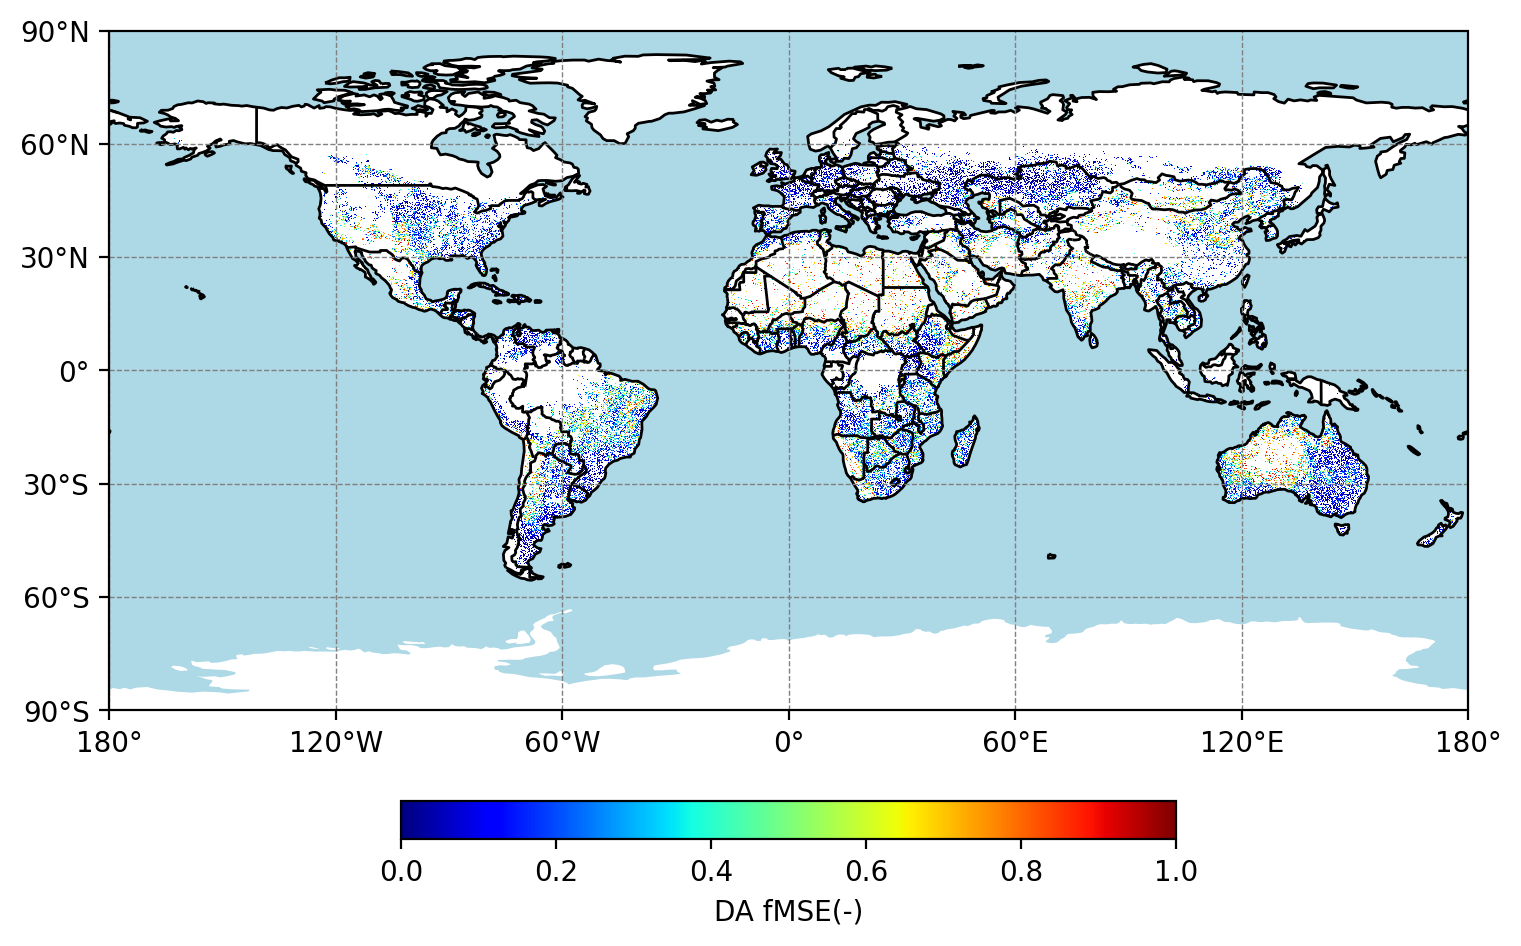

In [8]:
SMOS_fMSE  = fMSE['x'] #the lower the better
ASCAT_fMSE = fMSE['y'] #the lower the better
DA_fMSE    = fMSE['z'] #the lower the better

Plot.plot_global_map(domain_lon, domain_lat, SMOS_fMSE, 'SMOS fMSE(-)', 0, 1, 'jet')
Plot.plot_global_map(domain_lon, domain_lat, ASCAT_fMSE, 'ASCAT fMSE(-)', 0, 1, 'jet')
Plot.plot_global_map(domain_lon, domain_lat, DA_fMSE, 'DA fMSE(-)', 0, 1, 'jet')